# Deep Reinforcement Learning for Optimal Execution of Portfolio Transactions     

# Introduction

This notebook demonstrates how to use Deep Reinforcement Learning (DRL) for optimizing the execution of large portfolio transactions. We begin with a brief review of reinforcement learning and actor-critic methods.  Then, you will use an actor-critic method to generate optimal trading strategies that maximize profit when liquidating a block of shares.

# Actor-Critic Methods

In reinforcement learning, an agent makes observations and takes actions within an environment, and in return it receives rewards. Its objective is to learn to act in a way that will maximize its expected long-term rewards.

<br>
<figure>
  <img src = "./text_images/RL.png" width = 80% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Fig 1. - Reinforcement Learning.</figcaption>
</figure>
<br>

There are several types of RL algorithms, and they can be divided into three groups:

- **Critic-Only**: Critic-Only methods, also known as Value-Based methods, first find the optimal value function and then derive an optimal policy from it.


- **Actor-Only**: Actor-Only methods, also known as Policy-Based methods, search directly for the optimal policy in policy space. This is typically done by using a parameterized family of policies over which optimization procedures can be used directly.


- **Actor-Critic**: Actor-Critic methods combine the advantages of actor-only and critic-only methods. In this method, the critic learns the value function and uses it to determine how the actor's policy parramerters should be changed. In this case, the actor brings the advantage of computing continuous actions without the need for optimization procedures on a value function, while the critic supplies the actor with knowledge of the performance. Actor-critic methods usually have good convergence properties, in contrast to critic-only methods.  The **Deep Deterministic Policy Gradients (DDPG)** algorithm is one example of an actor-critic method.

<br>
<figure>
  <img src = "./text_images/Actor-Critic.png" width = 80% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Fig 2. - Actor-Critic Reinforcement Learning.</figcaption>
</figure>
<br>

In this notebook, you will use DDPG to determine the optimal execution of portfolio transactions. In other words, you will use the DDPG algorithm to solve the optimal liquidation problem. But before you can apply the DDPG algorithm we first need to formulate the optimal liquidation problem so that in can be solved using reinforcement learning. In the next section we will see how to do this.

# Modeling Optimal Execution as a Reinforcement Learning Problem

As we learned in the previous notebooks, the optimal liquidation problem is a minimization problem, *i.e.* we need to find the trading list that minimizes the implementation shortfall. In order to solve this problem through reinforcement learning, we need to restate the optimal liquidation problem in terms of **States**, **Actions**, and **Rewards**. Let's start by defining our States.

### States

The optimal liquidation problem entails that we sell all our shares within a given time frame. Therefore, our state vector must contain some information about the time remaining, or what is equivalent, the number trades remaning. We will use the latter and use the following features to define the state vector at time $t_k$:


$$
[r_{k-5},\, r_{k-4},\, r_{k-3},\, r_{k-2},\, r_{k-1},\, r_{k},\, m_{k},\, i_{k}]
$$

where:

- $r_{k} = \log\left(\frac{\tilde{S}_k}{\tilde{S}_{k-1}}\right)$ is the log-return at time $t_k$


- $m_{k} = \frac{N_k}{N}$ is the number of trades remaining at time $t_k$ normalized by the total number of trades.


- $i_{k} = \frac{x_k}{X}$ is the remaining number of shares at time $t_k$ normalized by the total number of shares.

The log-returns capture information about stock prices before time $t_k$, which can be used to detect possible price trends. The number of trades and shares remaining allow the agent to learn to sell all the shares within a given time frame. It is important to note that in real world trading scenarios, this state vector can hold many more variables.

### Actions

Since the optimal liquidation problem only requires us to sell stocks, it is reasonable to define the action $a_k$ to be the number of shares to sell at time $t_{k}$. However, if we start with millions of stocks, intepreting the action directly as the number of shares to sell at each time step can lead to convergence problems, because, the agent will need to produce actions with very high values. Instead, we will interpret the action $a_k$ as a **percentage**. In this case, the actions produced by the agent will only need to be between 0 and 1. Using this interpretation, we can determine the number of shares to sell at each time step using:

$$
n_k = a_k \times x_k
$$

where $x_k$ is the number of shares remaining at time $t_k$.

### Rewards

Defining the rewards is trickier than defining states and actions, since the original problem is a minimization problem. One option is to use the difference between two consecutive utility functions. Remeber the utility function is given by:

$$
U(x) = E(x) + λ V(x)
$$

After each time step, we compute the **utility using the equations for $E(x)$ and $V(x)$ from the Almgren and Chriss model for the remaining time and inventory while holding parameter λ constant.** Denoting the optimal trading trajectory computed at time $t$ as $x^*_t$, we define the reward as:

$$
R_{t} = {{U_t(x^*_t) - U_{t+1}(x^*_{t+1})}\over{U_t(x^*_t)}}
$$

Where we have normalized the difference to train the actor-critic model easier.

# Simulation Environment

In order to train our DDPG algorithm we will use a very simple simulated trading environment. This environment simulates stock prices that follow a discrete arithmetic random walk and that the permanent and temporary market impact functions are linear functions of the rate of trading, just like in the Almgren and Chriss model. This simple trading environment serves as a starting point to create more complex trading environments. You are encouraged to extend this simple trading environment by adding more complexity to simulte real world trading dynamics, such as book orders, network latencies, trading fees, etc...

The simulated enviroment is contained in the **syntheticChrissAlmgren.py** module. You are encouraged to take a look it and modify its parameters as you wish. Let's take a look at the default parameters of our simulation environment. We have set the intial stock price to be $S_0 = 50$, and the total number of shares to sell to one million. This gives an initial portfolio value of 50 Million dollars. We have also set the trader's risk aversion to $\lambda = 10^{-6}$.

The stock price will have 12\% annual volatility, a [bid-ask spread](https://www.investopedia.com/terms/b/bid-askspread.asp) of 1/8 and an average daily trading volume of 5 million shares. Assuming there are 250 trading days in a year, this gives a daily volatility in stock price of $0.12 / \sqrt{250} \approx 0.8\%$. We will use a liquiditation time of $T = 60$ days and we will set the number of trades $N = 60$. This means that $\tau=\frac{T}{N} = 1$ which means we will be making one trade per day.

For the temporary cost function we will set the fixed cost of selling to be 1/2 of the bid-ask spread, $\epsilon = 1/16$. we will set $\eta$ such that for each one percent of the daily volume we trade, we incur a price impact equal to the bid-ask
spread. For example, trading at a rate of $5\%$ of the daily trading volume incurs a one-time cost on each trade of 5/8. Under this assumption we have $\eta =(1/8)/(0.01 \times 5 \times 10^6) = 2.5 \times 10^{-6}$.

For the permanent costs, a common rule of thumb is that price effects become significant when we sell $10\%$ of the daily volume. If we suppose that significant means that the price depression is one bid-ask spread, and that the effect is linear for smaller and larger trading rates, then we have $\gamma = (1/8)/(0.1 \times 5 \times 10^6) = 2.5 \times 10^{-7}$.

The tables below summarize the default parameters of the simulation environment

In [ ]:
import utils

# Get the default financial and AC Model parameters
financial_params, ac_params = utils.get_env_param()

/home/heidar/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
financial_params

Annual Volatility:,12%,Bid-Ask Spread:,0.125
Daily Volatility:,0.8%,Daily Trading Volume:,"5,000,000"


In [ ]:
ac_params

NameError: name 'ac_params' is not defined

# Reinforcement Learning

In the code below we use **DDPG** to find a policy that can generate optimal trading trajectories that minimize implementation shortfall, and can be benchmarked against the Almgren and Chriss model. We will implement a typical reinforcement learning workflow to train the actor and critic using the simulation environment. We feed the states observed from our simulator to an agent. The Agent first predicts an action using the actor model and performs the action in the environment. Then, environment returns the reward and new state. This process continues for the given number of episodes. To get accurate results, you should run the code at least 10,000 episodes.

In [ ]:
import numpy as np
import sys

# Add the financial and finance directories to the system path from Google Drive
sys.path.append('/content/drive/MyDrive/financial/finance/')

import syntheticChrissAlmgren as sca
from ddpg_agent_first import Agent

from collections import deque

# Create simulation environment
env = sca.MarketEnvironment()

# Initialize Feed-forward DNNs for Actor and Critic models.
agent = Agent(state_size=env.observation_space_dimension(), action_size=env.action_space_dimension(), random_seed=0)

# Set the liquidation time
lqt = 60

# Set the number of trades
n_trades = 60

# Set trader's risk aversion
tr = 1e-6

# Set the number of episodes to run the simulation
episodes = 10000

shortfall_hist = np.array([])
shortfall_deque = deque(maxlen=100)

for episode in range(episodes):
    # Reset the enviroment
    cur_state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb = tr)

    # set the environment to make transactions
    env.start_transactions()

    for i in range(n_trades + 1):

        # Predict the best action for the current state.
        action = agent.act(cur_state, add_noise = True)

        # Action is performed and new state, reward, info are received.
        new_state, reward, done, info = env.step(action)

        # current state, action, reward, new state are stored in the experience replay
        agent.step(cur_state, action, reward, new_state, done)

        # roll over new state
        cur_state = new_state

        if info.done:
            shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
            shortfall_deque.append(info.implementation_shortfall)
            break

    if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque)))

print('\nAverage Implementation Shortfall: ${:,.2f} \n'.format(np.mean(shortfall_hist)))

Episode [100/10000]	Average Shortfall: $2,276,855.54
Episode [200/10000]	Average Shortfall: $2,562,256.53
Episode [300/10000]	Average Shortfall: $2,562,500.00
Episode [400/10000]	Average Shortfall: $2,562,500.00
Episode [500/10000]	Average Shortfall: $2,562,500.00
Episode [600/10000]	Average Shortfall: $2,562,500.00
Episode [700/10000]	Average Shortfall: $2,562,500.00
Episode [800/10000]	Average Shortfall: $2,562,500.00
Episode [900/10000]	Average Shortfall: $2,562,500.00
Episode [1000/10000]	Average Shortfall: $2,562,500.00
Episode [1100/10000]	Average Shortfall: $2,562,500.00
Episode [1200/10000]	Average Shortfall: $2,562,500.00
Episode [1300/10000]	Average Shortfall: $2,562,500.00
Episode [1400/10000]	Average Shortfall: $2,562,500.00
Episode [1500/10000]	Average Shortfall: $2,562,500.00
Episode [1600/10000]	Average Shortfall: $2,562,500.00
Episode [1700/10000]	Average Shortfall: $2,562,500.00
Episode [1800/10000]	Average Shortfall: $2,562,500.00
Episode [1900/10000]	Average Shortfal

KeyboardInterrupt: 

In [ ]:
sys.path.append('/content/drive/MyDrive/financial/finance/')

NameError: name 'sys' is not defined

# Todo

The above code should provide you with a starting framework for incorporating more complex dynamics into our model. Here are a few things you can try out:

- Explain why log-returns in a time window of 6 periods, along with $m_k$ and $i_k$ is a good choice for the state? Could you expand or shrink $D$ = number of past log-returns (which is considered $D=5$) to get better results?

- Incorporate your own reward function in the simulation environmet to see if you can achieve a expected shortfall that is better (lower) than that produced by the Almgren and Chriss model.


- Experiment rewarding the agent at every step and only giving a reward at the end. Which is; what happens if the reward function is sparse?


- Use more realistic price dynamics, such as geometric brownian motion (GBM). The equations used to model GBM can be found in section 3b of paper: GBM


- Try different functions for the action. You can change the values of the actions produced by the agent by using different functions. You can choose your function depending on the interpretation you give to the action. For example, you could set the action to be a **function of the trading rate**.


- Add more complex dynamics to the environment. Try incorporate trading fees, for example. This can be done by adding and extra term to the fixed cost of selling, $\epsilon$.

- Use SAC (soft actor-critic) and TD3 (Twin Delayed Deep Deterministic) with different hyperparameters and network structures to compare your results to DDPG results. Explain why this happens.

In [ ]:
# prompt: mount drive to this

from google.colab import drive
drive.mount('/content/drive')

setting the action function to be a function of the trading rate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python /content/drive/MyDrive/financial/finance/train.py --agent DDPG --episodes 5000 --risk_lambda 1e-5

--- Training DDPG Agent with Lambda=1e-05 ---
Episode 100/5000	Average Shortfall: $2,014,786.99
Episode 200/5000	Average Shortfall: $2,373,511.74
Episode 300/5000	Average Shortfall: $2,373,148.42
Episode 400/5000	Average Shortfall: $2,073,590.58
Episode 500/5000	Average Shortfall: $1,902,412.72
Episode 600/5000	Average Shortfall: $2,006,753.77
Episode 700/5000	Average Shortfall: $1,979,239.84
Episode 800/5000	Average Shortfall: $1,852,761.91
Episode 900/5000	Average Shortfall: $1,232,934.03
Episode 1000/5000	Average Shortfall: $1,709,417.95
Episode 1100/5000	Average Shortfall: $1,641,519.37
Episode 1200/5000	Average Shortfall: $1,333,195.37
Episode 1300/5000	Average Shortfall: $1,865,371.08
Episode 1400/5000	Average Shortfall: $2,131,311.35
Episode 1500/5000	Average Shortfall: $2,140,403.07
Episode 1600/5000	Average Shortfall: $2,101,116.12
Episode 1700/5000	Average Shortfall: $2,102,190.33
Episode 1800/5000	Average Shortfall: $2,098,535.81
Episode 1900/5000	Average Shortfall: $2,193,5

In [ ]:
!python /content/drive/MyDrive/financial/finance/train.py --agent DDPG --episodes 5000 --risk_lambda 1e-6

In [ ]:
!python /content/drive/MyDrive/financial/finance/train.py --agent TD3 --episodes 5000 --risk_lambda 1e-5

--- Training TD3 Agent with Lambda=1e-05 ---
Episode 100/5000	Average Shortfall: $1,669,956.73
Episode 200/5000	Average Shortfall: $2,292,464.79
Episode 300/5000	Average Shortfall: $2,347,772.67
Episode 400/5000	Average Shortfall: $2,380,498.38
Episode 500/5000	Average Shortfall: $2,353,893.89
Episode 600/5000	Average Shortfall: $2,217,159.05
Episode 700/5000	Average Shortfall: $2,116,633.06
Episode 800/5000	Average Shortfall: $2,072,926.39
Episode 900/5000	Average Shortfall: $2,056,322.55
Episode 1000/5000	Average Shortfall: $2,054,871.60
Episode 1100/5000	Average Shortfall: $2,109,006.08
Episode 1200/5000	Average Shortfall: $2,117,275.52
Episode 1300/5000	Average Shortfall: $2,187,393.43
Episode 1400/5000	Average Shortfall: $2,146,007.78
Episode 1500/5000	Average Shortfall: $2,106,452.70
Episode 1600/5000	Average Shortfall: $2,116,699.41
Episode 1700/5000	Average Shortfall: $2,096,312.86
Episode 1800/5000	Average Shortfall: $2,141,206.05
Episode 1900/5000	Average Shortfall: $2,098,91

In [ ]:
!python /content/drive/MyDrive/financial/finance/train.py --agent TD3 --episodes 5000 --risk_lambda 1e-6

In [ ]:
!python /content/drive/MyDrive/financial/finance/train.py --agent SAC --episodes 5000 --risk_lambda 1e-6

--- Training SAC Agent with Lambda=1e-06 ---
Episode 100/5000	Average Shortfall: $1,485,664.78
Episode 200/5000	Average Shortfall: $1,636,917.47
Episode 300/5000	Average Shortfall: $1,592,638.87
Episode 400/5000	Average Shortfall: $1,580,823.42
Episode 500/5000	Average Shortfall: $1,536,808.26
Episode 600/5000	Average Shortfall: $1,574,150.37
Episode 700/5000	Average Shortfall: $1,570,485.63
Episode 800/5000	Average Shortfall: $1,660,245.08
Episode 900/5000	Average Shortfall: $1,742,351.15
Episode 1000/5000	Average Shortfall: $1,820,233.31
Episode 1100/5000	Average Shortfall: $1,881,717.01
Episode 1200/5000	Average Shortfall: $2,105,048.28
Episode 1300/5000	Average Shortfall: $2,171,354.90
Episode 1400/5000	Average Shortfall: $2,281,310.11
Episode 1500/5000	Average Shortfall: $2,398,541.80
Episode 1600/5000	Average Shortfall: $2,405,583.50
Episode 1700/5000	Average Shortfall: $1,845,754.33
Episode 1800/5000	Average Shortfall: $1,619,663.51
Episode 1900/5000	Average Shortfall: $1,638,39

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.1 MB/s eta 0:00:00


In [ ]:
!python /content/drive/MyDrive/financial/finance/optimize.py --agent TD3 --n_trials 10 --episodes_per_trial 3000

[I 2025-07-21 14:23:41,304] A new study created in RDB with name: TD3-study

--- Starting Trial 0 for TD3 ---
Parameters: LR_Actor=0.000241, LR_Critic=0.000031, FC1=32, FC2=48, Policy_Noise=0.34
--- Training TD3 Agent with Lambda=1e-06 ---
Episode 100/3000	Average Shortfall: $2,038,131.77
Episode 200/3000	Average Shortfall: $2,391,115.57
Episode 300/3000	Average Shortfall: $2,434,908.52
Episode 400/3000	Average Shortfall: $2,364,419.83
Episode 500/3000	Average Shortfall: $2,385,605.35
Episode 600/3000	Average Shortfall: $2,401,007.87
Episode 700/3000	Average Shortfall: $2,382,182.51
Episode 800/3000	Average Shortfall: $2,440,612.53
Episode 900/3000	Average Shortfall: $2,420,188.17
Episode 1000/3000	Average Shortfall: $2,394,077.94
Episode 1100/3000	Average Shortfall: $2,411,578.13
Episode 1200/3000	Average Shortfall: $2,395,608.79
Episode 1300/3000	Average Shortfall: $2,386,004.98
Episode 1400/3000	Average Shortfall: $2,400,818.40
Episode 1500/3000	Average Shortfall: $2,400,737.71
Epis

In [ ]:
!python /content/drive/MyDrive/financial/finance/optimize.py --agent SAC --n_trials 30 --episodes_per_trial 3000

--- Starting new optimization study for SAC with 30 trials ---
[I 2025-07-22 20:00:53,541] Using an existing study with name 'SAC-study' instead of creating a new one.

--- Starting Trial 0 for SAC ---
Parameters: LR_Actor=0.000066, LR_Critic=0.000029, FC1=24, FC2=128, Policy_Noise=0.00
--- Training SAC Agent with Lambda=1e-06 (Seed: 0) ---
Episode 100/3000	Average Shortfall: $1,413,689.43
Episode 200/3000	Average Shortfall: $1,538,584.08
Episode 300/3000	Average Shortfall: $1,597,834.90
Episode 400/3000	Average Shortfall: $1,703,216.20
Episode 500/3000	Average Shortfall: $1,705,317.95
Episode 600/3000	Average Shortfall: $1,694,239.93
Episode 700/3000	Average Shortfall: $1,590,558.88
Episode 800/3000	Average Shortfall: $1,653,083.82
Episode 900/3000	Average Shortfall: $1,626,593.73
Episode 1000/3000	Average Shortfall: $1,572,839.99
Episode 1100/3000	Average Shortfall: $1,572,212.59
Episode 1200/3000	Average Shortfall: $1,240,418.28
Episode 1300/3000	Average Shortfall: $1,113,600.38
Epi

In [ ]:
!python /content/drive/MyDrive/financial/finance/run_experiments.py


##################################################
## RUNNING ALL EXPERIMENTS FOR SEED: 123 ##
##################################################

▶️ Starting Experiment: TD3_best (Seed: 123)
--- Training TD3 Agent with Lambda=1e-07 (Seed: 123) ---
Episode 100/3000	Average Shortfall: $2,189,805.07
Episode 200/3000	Average Shortfall: $2,395,502.08
Episode 300/3000	Average Shortfall: $2,395,565.00
Episode 400/3000	Average Shortfall: $2,382,361.16
Episode 500/3000	Average Shortfall: $2,125,905.08
Episode 600/3000	Average Shortfall: $1,973,843.89
Episode 700/3000	Average Shortfall: $2,110,613.47
Episode 800/3000	Average Shortfall: $2,073,474.98
Episode 900/3000	Average Shortfall: $2,040,383.20
Episode 1000/3000	Average Shortfall: $2,014,320.29
Episode 1100/3000	Average Shortfall: $1,998,298.21
Episode 1200/3000	Average Shortfall: $2,123,506.42
Episode 1300/3000	Average Shortfall: $2,080,755.13
Episode 1400/3000	Average Shortfall: $2,106,200.32
Episode 1500/3000	Average Shortfall: $2,095,5

Could not find results for TD3_best. Please check the file exists.
Could not find results for TD3_high_lr. Please check the file exists.
Could not find results for TD3_low_noise. Please check the file exists.
Could not find results for SAC_best. Please check the file exists.
Could not find results for SAC_small_net. Please check the file exists.
Loaded DDPG_baseline data.

--- Plotting Best Agent Comparison ---


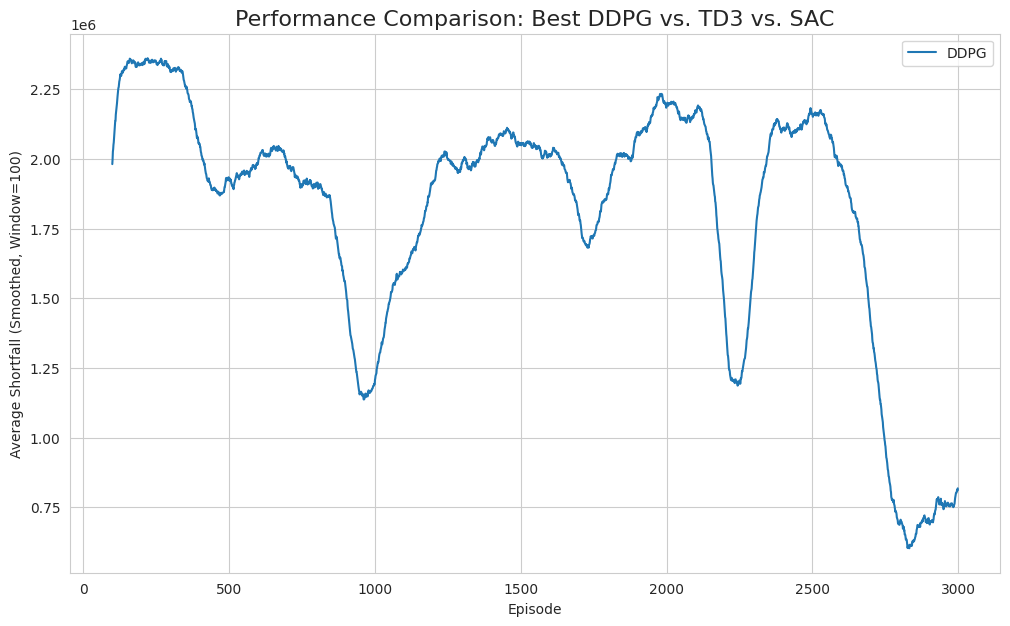


--- Plotting Within-Agent Comparison for TD3 ---


/tmp/ipython-input-14-317169213.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


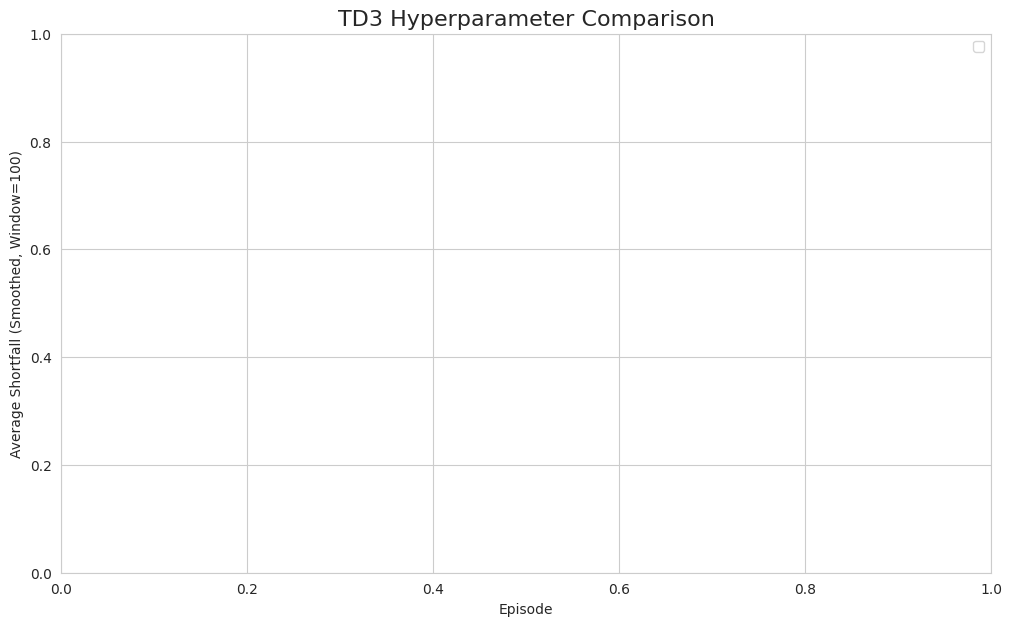


--- Plotting Within-Agent Comparison for SAC ---


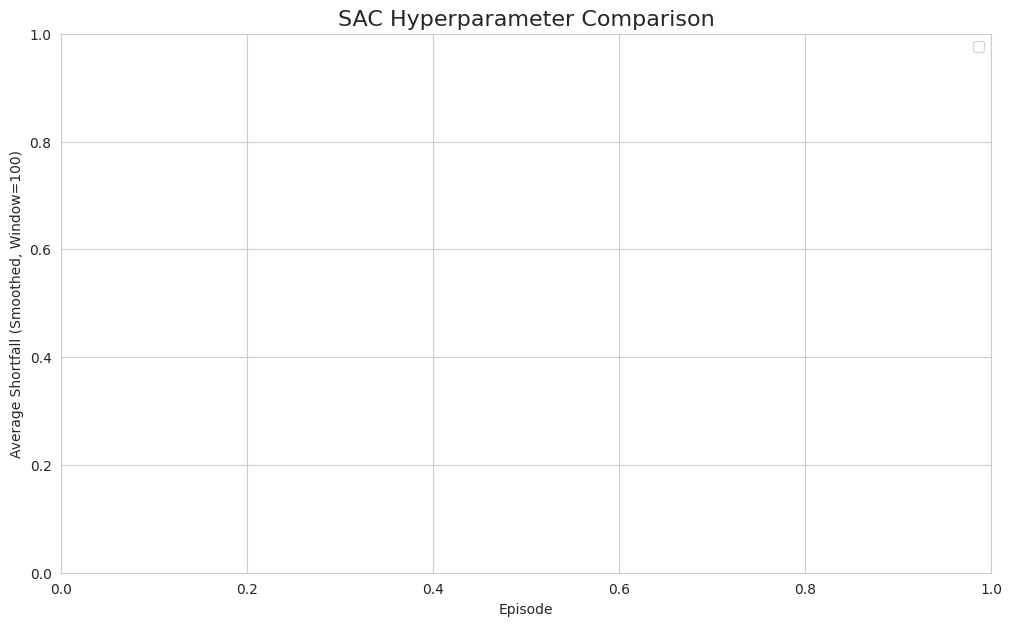


--- Plotting Final Performance Distribution ---


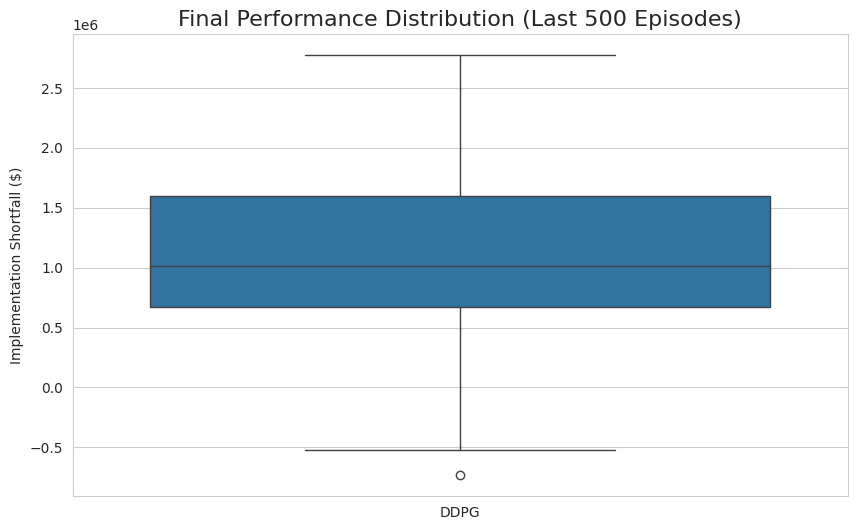

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# --- 1. Load Data for All Experiments ---
# Names should match the 'name' field in your run_experiments.py script
config_names = [
    'TD3_best', 'TD3_high_lr', 'TD3_low_noise',
    'SAC_best', 'SAC_small_net','DDPG_baseline'

]

results = {}
for name in config_names:
    try:
        results[name] = pd.read_csv(f'results_{name}.csv')
        print(f"Loaded {name} data.")
    except FileNotFoundError:
        print(f"Could not find results for {name}. Please check the file exists.")

# Define a function for plotting smoothed learning curves
def plot_learning_curves(data_dict, title, window=100):
    plt.figure()
    for name, df in data_dict.items():
        smoothed_shortfall = df['shortfall'].rolling(window=window).mean()
        plt.plot(smoothed_shortfall, label=name)
    plt.title(title, fontsize=16)
    plt.xlabel('Episode')
    plt.ylabel(f'Average Shortfall (Smoothed, Window={window})')
    plt.legend()
    plt.show()

# --- 2. Compare Best Agents (TD3 vs. SAC vs. DDPG) ---
print("\n--- Plotting Best Agent Comparison ---")
best_agents_data = {
    'TD3': results.get('TD3_best'),
    'SAC': results.get('SAC_best'),
    'DDPG': results.get('DDPG_baseline')
}
# Filter out any models that failed to load
best_agents_data = {k: v for k, v in best_agents_data.items() if v is not None}
plot_learning_curves(best_agents_data, 'Performance Comparison: Best DDPG vs. TD3 vs. SAC')

# --- 3. Compare Within Agents (Effect of Hyperparameters) ---
print("\n--- Plotting Within-Agent Comparison for TD3 ---")
td3_comparison_data = {
    'TD3 (Best)': results.get('TD3_best'),
    'TD3 (High Learning Rate)': results.get('TD3_high_lr'),
    'TD3 (Low Policy Noise)': results.get('TD3_low_noise')
}
td3_comparison_data = {k: v for k, v in td3_comparison_data.items() if v is not None}
plot_learning_curves(td3_comparison_data, 'TD3 Hyperparameter Comparison')

# --- 3b. Compare Within Agents (Effect of Hyperparameters for SAC) ---
print("\n--- Plotting Within-Agent Comparison for SAC ---")

# Define the SAC configurations you want to compare
sac_comparison_data = {
    'SAC (Best)': results.get('SAC_best'),
    'SAC (High Learning Rate)': results.get('SAC_high_lr'),
    'SAC (Small Network)': results.get('SAC_small_net')
}

# Filter out any models that failed to load
sac_comparison_data = {k: v for k, v in sac_comparison_data.items() if v is not None}

# Create the plot using the function you already defined
plot_learning_curves(sac_comparison_data, 'SAC Hyperparameter Comparison')


# --- 4. Final Performance Distribution (Box Plot) ---
print("\n--- Plotting Final Performance Distribution ---")
final_performance_data = []
labels = []

for name, df in best_agents_data.items():
    # Use the last 500 episodes as the "final performance"
    final_shortfalls = df['shortfall'].iloc[-500:]
    final_performance_data.append(final_shortfalls)
    labels.append(name)

plt.figure(figsize=(10, 6))
sns.boxplot(data=final_performance_data)
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.title('Final Performance Distribution (Last 500 Episodes)', fontsize=16)
plt.ylabel('Implementation Shortfall ($)')
plt.show()

--- Searching for result files ---
✅ Loaded results_TD3_best_seed_123.csv
✅ Loaded results_SAC_best_seed_123.csv
✅ Loaded results_DDPG_baseline_seed_123.csv

--- Data loading complete. Generating plots... ---


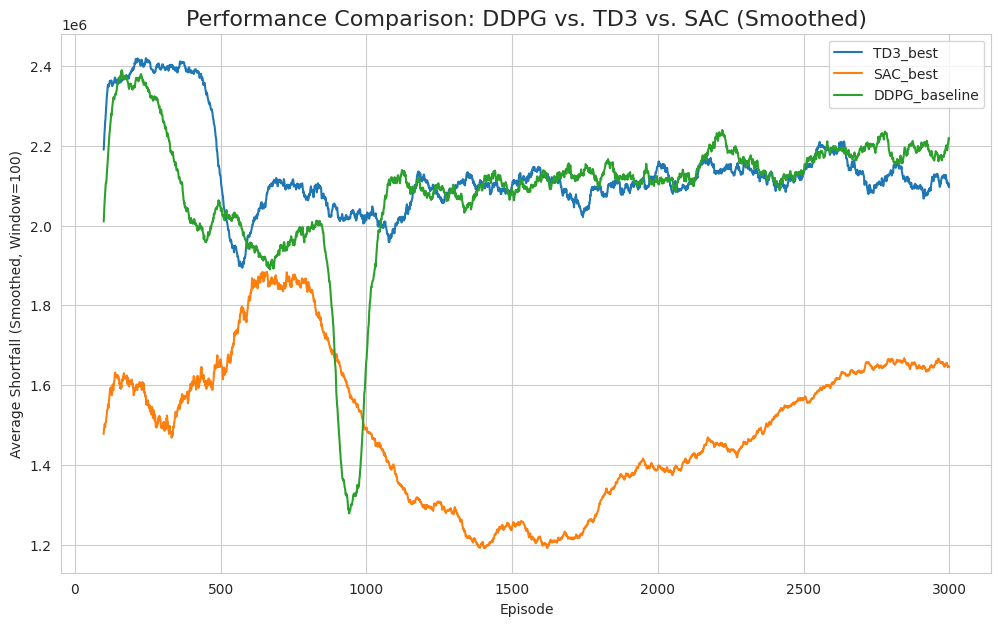

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# --- SETTINGS ---
# Make sure this matches the seeds from your experiment run
SEEDS = [123]
WINDOW = 100
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# --- 1. Load Data ---
config_names = [
    'TD3_best', 'SAC_best', 'DDPG_baseline'
]

all_results = []
print("--- Searching for result files ---")
for name in config_names:
    for seed in SEEDS:
        try:
            filename = f'results_{name}_seed_{seed}.csv'
            df = pd.read_csv(filename)
            df['config'] = name
            df['seed'] = seed
            df['episode'] = np.arange(len(df))
            all_results.append(df)
            print(f"✅ Loaded {filename}")
        except FileNotFoundError:
            print(f"⚪️ File not found for '{name}' with seed {seed}. Skipping.")

if not all_results:
    print("\nERROR: No data files were found. Please run the corrected `run_experiments.py` script.")
else:
    results_df = pd.concat(all_results, ignore_index=True)
    results_df['smoothed_shortfall'] = results_df.groupby(['config', 'seed'])['shortfall'].transform(lambda s: s.rolling(WINDOW).mean())
    print("\n--- Data loading complete. Generating plots... ---")
   # --- 2. Plotting (Corrected with Smoothing) ---
    plt.figure()

# PLOT THE SMOOTHED DATA to see the learning trend clearly
    sns.lineplot(data=results_df, x='episode', y='smoothed_shortfall', hue='config')

    plt.title('Performance Comparison: DDPG vs. TD3 vs. SAC (Smoothed)', fontsize=16)
    plt.xlabel('Episode')
    plt.ylabel('Average Shortfall (Smoothed, Window=100)')
    plt.legend()
    plt.show()

In [ ]:
!python /content/drive/MyDrive/financial/finance/run_experiments.py


##################################################
## RUNNING ALL EXPERIMENTS FOR SEED: 42 ##
##################################################

▶️ Starting Experiment: DDPG_baseline (Seed: 42)
--- Training DDPG Agent with Lambda=1e-06 (Seed: 42) ---
Episode 100/10000	Average Shortfall: $2,013,166.78
Episode 200/10000	Average Shortfall: $2,372,370.28
Episode 300/10000	Average Shortfall: $2,377,243.04
Episode 400/10000	Average Shortfall: $2,138,909.61
Episode 500/10000	Average Shortfall: $1,879,183.96
Episode 600/10000	Average Shortfall: $1,939,331.14
Episode 700/10000	Average Shortfall: $2,008,565.74
Episode 800/10000	Average Shortfall: $1,518,183.18
Episode 900/10000	Average Shortfall: $1,278,481.38
Episode 1000/10000	Average Shortfall: $1,985,071.62
Episode 1100/10000	Average Shortfall: $1,876,332.06
Episode 1200/10000	Average Shortfall: $1,680,284.61
Episode 1300/10000	Average Shortfall: $935,021.91
Episode 1400/10000	Average Shortfall: $1,585,116.44
Episode 1500/10000	Average Sho

Loading and processing data...
  - Successfully loaded results_DDPG_baseline_seed_42.csv
  - Successfully loaded results_SAC_best_seed_42.csv


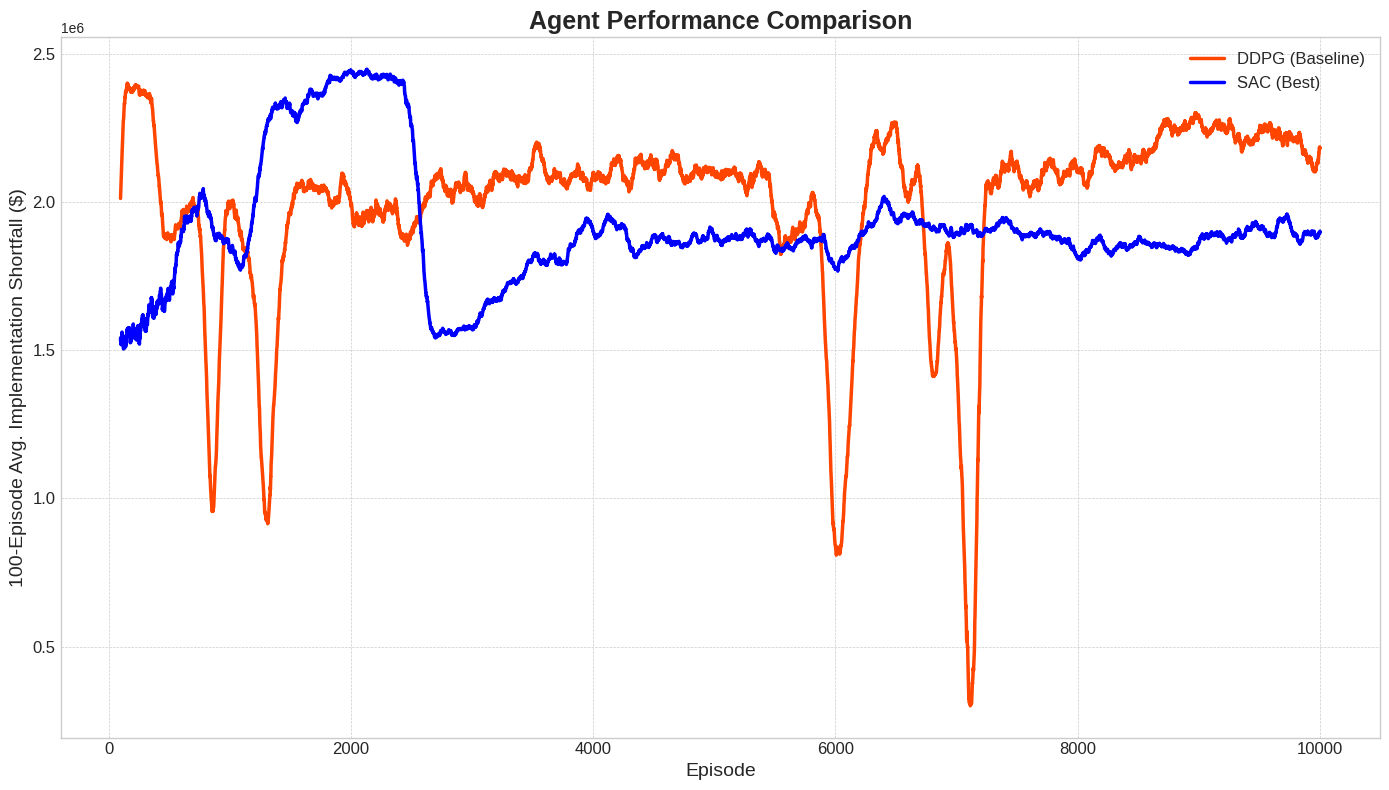


Final Performance (Average of last 100 episodes)
DDPG (Baseline)     : $2,181,288.42
SAC (Best)          : $1,900,803.16


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


experiments_to_plot = [
    {
        'name': 'DDPG (Baseline)',
        'filename': 'results_DDPG_baseline_seed_42.csv',
        'color': 'orangered'
    },

    {
        'name': 'SAC (Best)',
        'filename': 'results_SAC_best_seed_42.csv',
        'color': 'blue'
    }
]

plot_data = {}
window_size = 100

print("Loading and processing data...")
for experiment in experiments_to_plot:
    try:
        df = pd.read_csv(experiment['filename'])
        moving_avg = df['shortfall'].rolling(window=window_size).mean()
        plot_data[experiment['name']] = {
            'data': df,
            'moving_avg': moving_avg,
            'color': experiment['color']
        }
        print(f"  - Successfully loaded {experiment['filename']}")
    except FileNotFoundError:
        print(f"  {experiment['filename']}. Skipping.")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

for name, data in plot_data.items():
    ax.plot(data['moving_avg'].index, data['moving_avg'], label=name, color=data['color'], linewidth=2.5)

ax.set_title('Agent Performance Comparison', fontsize=18, weight='bold')
ax.set_xlabel('Episode', fontsize=14)
ax.set_ylabel(f'{window_size}-Episode Avg. Implementation Shortfall ($)', fontsize=14)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Final Performance (Average of last 100 episodes)")
print("="*50)
for name, data in plot_data.items():
    final_performance = data['data']['shortfall'].tail(100).mean()
    print(f"{name:<20}: ${final_performance:,.2f}")
print("="*50)

In [ ]:
import numpy as np
import sys
from collections import deque
import pandas as pd
import torch

# Add the financial and finance directories to the system path
# sys.path.append('/content/drive/MyDrive/financial/finance/')

import syntheticChrissAlmgren as sca
from ppo_agent import PPOAgent

# --- PPO Hyperparameters ---
UPDATE_TIMESTEP = 2000 # The number of steps to run before updating the policy
K_EPOCHS = 80          # Number of times to update the policy with the same batch of data
EPS_CLIP = 0.2         # PPO clipping parameter
GAMMA = 0.99           # Discount factor
LR_ACTOR = 0.0003
LR_CRITIC = 0.001

# --- Simulation Parameters ---
# Create simulation environment
env = sca.MarketEnvironment()

# Initialize PPO agent
agent = PPOAgent(state_dim=env.observation_space_dimension(),
                 action_dim=env.action_space_dimension(),
                 lr_actor=LR_ACTOR,
                 lr_critic=LR_CRITIC,
                 gamma=GAMMA,
                 K_epochs=K_EPOCHS,
                 eps_clip=EPS_CLIP)

# Set the liquidation time
lqt = 60
# Set the number of trades
n_trades = 60
# Set trader's risk aversion
tr = 1e-6
# Set the number of episodes to run the simulation
episodes = 5000

# --- Training Setup ---
shortfall_hist = np.array([])
shortfall_deque = deque(maxlen=100)
time_step = 0

# --- Main Training Loop ---
for episode in range(episodes):
    # Reset the enviroment
    cur_state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb = tr)

    # set the environment to make transactions
    env.start_transactions()

    for i in range(n_trades + 1):
        time_step += 1

        # Predict the best action for the current state.
        action = agent.act(cur_state)

        # Action is performed and new state, reward, info are received.
        new_state, reward, done, info = env.step(action)

        # --- PPO Specific: Store reward and done flag in buffer ---
        agent.buffer.rewards.append(reward)
        agent.buffer.is_terminals.append(done)

        # --- PPO Specific: Update policy periodically ---
        if time_step % UPDATE_TIMESTEP == 0:
            agent.update()

        # roll over new state
        cur_state = new_state

        if info.done:
            shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
            shortfall_deque.append(info.implementation_shortfall)
            break

    if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque)))

# --- Final Results and Saving ---
print('\nAverage Implementation Shortfall: ${:,.2f} \n'.format(np.mean(shortfall_hist)))

# 1. Save the performance history to a CSV file
results_df = pd.DataFrame(shortfall_hist, columns=['shortfall'])
csv_filename = 'results_PPO.csv'
results_df.to_csv(csv_filename, index=False)
print(f"Performance history saved to {csv_filename}")

# 2. Save the trained agent's model weights
model_filename = 'PPO_model.pth'
agent.save(model_filename)
print(f"Trained model saved to {model_filename}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2000, 1])) that is different to the input size (torch.Size([2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode [100/5000]	Average Shortfall: $1,045,110.90
Episode [200/5000]	Average Shortfall: $1,015,201.84
Episode [300/5000]	Average Shortfall: $993,988.39
Episode [400/5000]	Average Shortfall: $997,371.61
Episode [500/5000]	Average Shortfall: $1,016,431.90
Episode [600/5000]	Average Shortfall: $1,009,822.85
Episode [700/5000]	Average Shortfall: $1,033,824.69
Episode [800/5000]	Average Shortfall: $1,087,070.89
Episode [900/5000]	Average Shortfall: $1,019,968.25
Episode [1000/5000]	Average Shortfall: $1,015,791.75
Episode [1100/5000]	Average Shortfall: $1,041,344.81
Episode [1200/5000]	Average Shortfall: $1,000,578.92
Episode [1300/5000]	Average Shortfall: $1,037,421.74
Episode [1400/5000]	Average Shortfall: $1,005,450.52
Episode [1500/5000]	Average Shortfall: $987,188.10
Episode [1600/5000]	Average Shortfall: $1,007,500.48
Episode [1700/5000]	Average Shortfall: $989,122.34
Episode [1800/5000]	Average Shortfall: $986,409.47
Episode [1900/5000]	Average Shortfall: $978,644.40
Episode [2000/

In [9]:
import pandas as pd
import numpy as np
from collections import deque
import torch

# Make sure your environment and agent files are accessible
import syntheticChrissAlmgren as sca
from ppo_agent import PPOAgent

# --- HYPERPARAMETERS ---
# <<< FIX: Reduced the update timestep to prevent GPU memory errors >>>
UPDATE_TIMESTEP = 512

EPISODES = 3000
N_TRADES = 60
RISK_LAMBDA = 2e-7 # The value from your log
LR_ACTOR = 0.0003
LR_CRITIC = 0.001
GAMMA = 0.99
K_EPOCHS = 80
EPS_CLIP = 0.2

# --- INITIALIZATION ---
env = sca.MarketEnvironment()
state_dim = env.observation_space_dimension()
action_dim = env.action_space_dimension()

agent = PPOAgent(state_dim=state_dim,
                 action_dim=action_dim,
                 lr_actor=LR_ACTOR,
                 lr_critic=LR_CRITIC,
                 gamma=GAMMA,
                 K_epochs=K_EPOCHS,
                 eps_clip=EPS_CLIP)

# --- TRAINING SETUP ---
shortfall_hist = []
shortfall_deque = deque(maxlen=100)
time_step = 0

print("--- Starting PPO Training ---")
for episode in range(1, EPISODES + 1):
    cur_state = env.reset(seed=episode, num_trades=N_TRADES, lamb=RISK_LAMBDA)
    env.start_transactions()

    for i in range(N_TRADES + 1):
        time_step += 1
        action = agent.act(cur_state)
        new_state, reward, done, info = env.step(action)

        agent.buffer.rewards.append(reward)
        agent.buffer.is_terminals.append(done)

        if time_step % UPDATE_TIMESTEP == 0:
            agent.update()

        cur_state = new_state
        if info.done:
            shortfall_hist.append(info.implementation_shortfall)
            shortfall_deque.append(info.implementation_shortfall)
            break

    if episode % 100 == 0:
        print(f'\rEpisode [{episode}/{EPISODES}]\tAverage Shortfall: ${np.mean(shortfall_deque):,.2f}')

# --- SAVE RESULTS ---
print(f'\nAverage Implementation Shortfall: ${np.mean(shortfall_hist):,.2f} \n')

df = pd.DataFrame(shortfall_hist, columns=['shortfall'])
csv_filename = 'results_PPO_3k.csv'
df.to_csv(csv_filename, index=False)
print(f"✅ Performance history saved to {csv_filename}")

model_filename = 'PPO_3k_model.pth'
agent.save(model_filename)
print(f"✅ Trained model saved to {model_filename}")

--- Starting PPO Training ---
Episode [100/3000]	Average Shortfall: $1,206,395.59
Episode [200/3000]	Average Shortfall: $1,184,428.08
Episode [300/3000]	Average Shortfall: $1,144,876.64
Episode [400/3000]	Average Shortfall: $1,174,863.45
Episode [500/3000]	Average Shortfall: $1,143,882.87
Episode [600/3000]	Average Shortfall: $1,143,570.45
Episode [700/3000]	Average Shortfall: $1,201,499.00
Episode [800/3000]	Average Shortfall: $1,142,692.12
Episode [900/3000]	Average Shortfall: $1,160,169.33
Episode [1000/3000]	Average Shortfall: $1,141,232.66
Episode [1100/3000]	Average Shortfall: $1,111,777.74
Episode [1200/3000]	Average Shortfall: $1,191,753.44
Episode [1300/3000]	Average Shortfall: $1,164,815.33
Episode [1400/3000]	Average Shortfall: $1,153,997.44
Episode [1500/3000]	Average Shortfall: $1,154,500.33
Episode [1600/3000]	Average Shortfall: $1,171,801.61
Episode [1700/3000]	Average Shortfall: $1,147,529.89
Episode [1800/3000]	Average Shortfall: $1,175,697.83
Episode [1900/3000]	Avera

In [ ]:
import pandas as pd
import numpy as np
from collections import deque
import torch

# Make sure your environment and agent files are accessible
import syntheticChrissAlmgren as sca
from ppo_agent import PPOAgent

# --- HYPERPARAMETERS ---
# <<< FIX: Reduced the update timestep to prevent GPU memory errors >>>
UPDATE_TIMESTEP = 512

EPISODES = 10000
N_TRADES = 60
RISK_LAMBDA = 2e-7 # The value from your log
LR_ACTOR = 0.0003
LR_CRITIC = 0.001
GAMMA = 0.99
K_EPOCHS = 80
EPS_CLIP = 0.2

# --- INITIALIZATION ---
env = sca.MarketEnvironment()
state_dim = env.observation_space_dimension()
action_dim = env.action_space_dimension()

agent = PPOAgent(state_dim=state_dim,
                 action_dim=action_dim,
                 lr_actor=LR_ACTOR,
                 lr_critic=LR_CRITIC,
                 gamma=GAMMA,
                 K_epochs=K_EPOCHS,
                 eps_clip=EPS_CLIP)

# --- TRAINING SETUP ---
shortfall_hist = []
shortfall_deque = deque(maxlen=100)
time_step = 0

print("--- Starting PPO Training ---")
for episode in range(1, EPISODES + 1):
    cur_state = env.reset(seed=episode, num_trades=N_TRADES, lamb=RISK_LAMBDA)
    env.start_transactions()

    for i in range(N_TRADES + 1):
        time_step += 1
        action = agent.act(cur_state)
        new_state, reward, done, info = env.step(action)

        agent.buffer.rewards.append(reward)
        agent.buffer.is_terminals.append(done)

        if time_step % UPDATE_TIMESTEP == 0:
            agent.update()

        cur_state = new_state
        if info.done:
            shortfall_hist.append(info.implementation_shortfall)
            shortfall_deque.append(info.implementation_shortfall)
            break

    if episode % 100 == 0:
        print(f'\rEpisode [{episode}/{EPISODES}]\tAverage Shortfall: ${np.mean(shortfall_deque):,.2f}')

# --- SAVE RESULTS ---
print(f'\nAverage Implementation Shortfall: ${np.mean(shortfall_hist):,.2f} \n')

df = pd.DataFrame(shortfall_hist, columns=['shortfall'])
csv_filename = 'results_PPO_3k.csv'
df.to_csv(csv_filename, index=False)
print(f"Performance history saved to {csv_filename}")

model_filename = 'PPO_3k_model.pth'
agent.save(model_filename)
print(f" Trained model saved to {model_filename}")

--- Starting PPO Training ---
Episode [100/10000]	Average Shortfall: $1,021,956.54
Episode [200/10000]	Average Shortfall: $1,017,266.64
Episode [300/10000]	Average Shortfall: $999,790.38
Episode [400/10000]	Average Shortfall: $1,021,017.65
Episode [500/10000]	Average Shortfall: $1,005,281.85
Episode [600/10000]	Average Shortfall: $996,380.63
Episode [700/10000]	Average Shortfall: $1,031,138.98
Episode [800/10000]	Average Shortfall: $1,006,222.34
Episode [900/10000]	Average Shortfall: $986,520.88
Episode [1000/10000]	Average Shortfall: $950,514.85
Episode [1100/10000]	Average Shortfall: $990,986.46
Episode [1200/10000]	Average Shortfall: $1,007,525.08
Episode [1300/10000]	Average Shortfall: $1,055,353.39
Episode [1400/10000]	Average Shortfall: $1,026,413.38
Episode [1500/10000]	Average Shortfall: $1,018,308.39
Episode [1600/10000]	Average Shortfall: $1,017,491.43
Episode [1700/10000]	Average Shortfall: $980,725.15
Episode [1800/10000]	Average Shortfall: $1,011,022.17
Episode [1900/10000


--- Plotting Performance ---


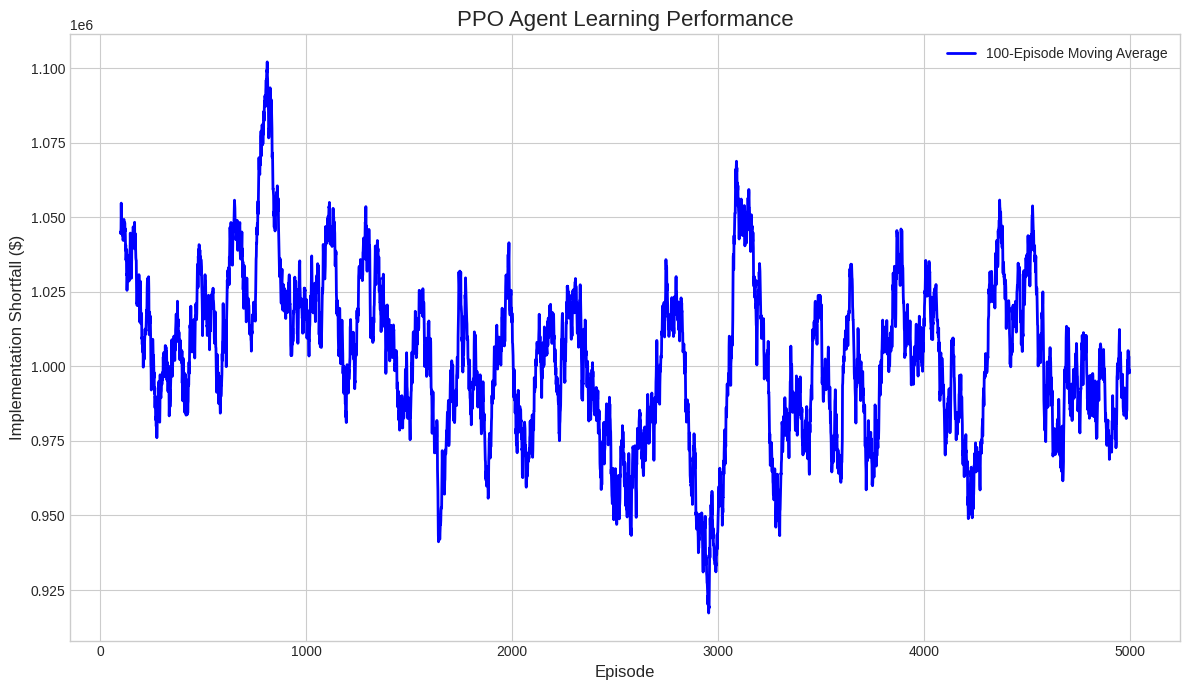


--- Plotting Strategy from a Test Episode ---


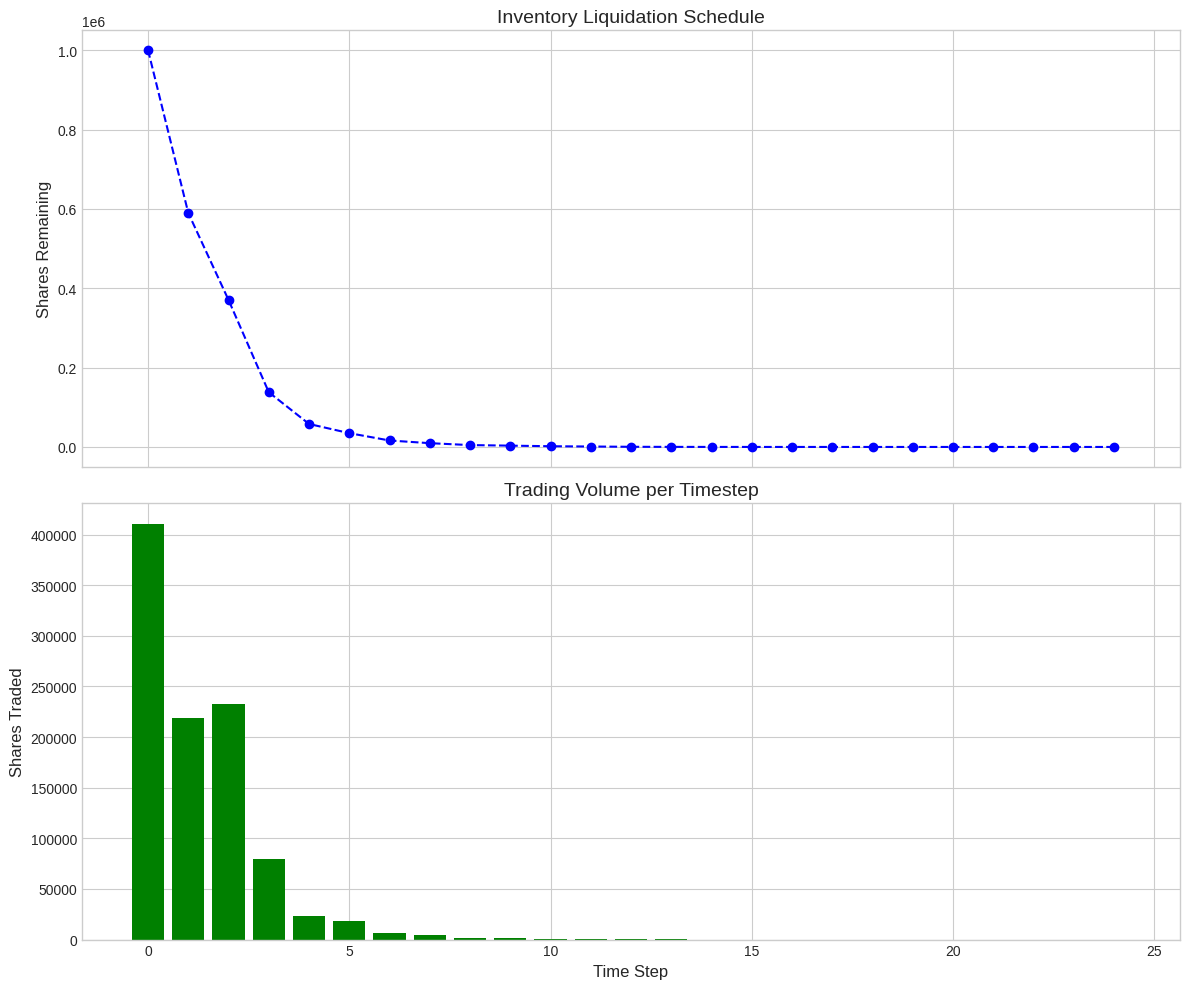

In [ ]:
# Performance Plot
import matplotlib.pyplot as plt
print("\n--- Plotting Performance ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))
results_df = pd.DataFrame(shortfall_hist, columns=['shortfall'])
window_size = 100
moving_avg = results_df['shortfall'].rolling(window=window_size).mean()
ax.plot(moving_avg.index, moving_avg, label=f'{window_size}-Episode Moving Average', color='blue', linewidth=2)
ax.set_title('PPO Agent Learning Performance', fontsize=16)
ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Implementation Shortfall ($)', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

# Strategy Plot
print("\n--- Plotting Strategy from a Test Episode ---")
strategy_log = []
state = env.reset(seed=42, liquid_time=lqt, num_trades=n_trades, lamb=tr) # Use a fixed seed for consistency
env.start_transactions()

for t in range(n_trades + 1):
    log_entry = {'time': t, 'inventory': env.shares_remaining}
    action = agent.act(state)
    state, _, done, _ = env.step(action)
    log_entry['action_volume'] = (log_entry['inventory'] - env.shares_remaining)
    strategy_log.append(log_entry)
    if done:
        break
strategy_df = pd.DataFrame(strategy_log)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax1.plot(strategy_df['time'], strategy_df['inventory'], color='blue', marker='o', linestyle='--')
ax1.set_title('Inventory Liquidation Schedule', fontsize=14)
ax1.set_ylabel('Shares Remaining', fontsize=12)
ax1.grid(True)
ax2.bar(strategy_df['time'], strategy_df['action_volume'], color='green')
ax2.set_title('Trading Volume per Timestep', fontsize=14)
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Shares Traded', fontsize=12)
ax2.grid(True)
plt.tight_layout()
plt.show()

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/financial-20250724T092407Z-1-001/financial/finance')

changing lambda
lr_actor
update_timestamp

In [ ]:
import numpy as np
import sys
from collections import deque
import pandas as pd
import torch

# Add the financial and finance directories to the system path
# sys.path.append('/content/drive/MyDrive/financial/finance/')

import syntheticChrissAlmgren as sca
from ppo_agent import PPOAgent

# --- PPO Hyperparameters ---
UPDATE_TIMESTEP = 2000 # The number of steps to run before updating the policy
K_EPOCHS = 80          # Number of times to update the policy with the same batch of data
EPS_CLIP = 0.2         # PPO clipping parameter
GAMMA = 0.99           # Discount factor
LR_ACTOR = 0.0003
LR_CRITIC = 0.001

# --- Simulation Parameters ---
# Create simulation environment
env = sca.MarketEnvironment()

# Initialize PPO agent
agent = PPOAgent(state_dim=env.observation_space_dimension(),
                 action_dim=env.action_space_dimension(),
                 lr_actor=LR_ACTOR,
                 lr_critic=LR_CRITIC,
                 gamma=GAMMA,
                 K_epochs=K_EPOCHS,
                 eps_clip=EPS_CLIP)

# Set the liquidation time
lqt = 60
# Set the number of trades
n_trades = 60
# Set trader's risk aversion
tr = 1e-7
# Set the number of episodes to run the simulation
episodes = 5000

# --- Training Setup ---
shortfall_hist = np.array([])
shortfall_deque = deque(maxlen=100)
time_step = 0

# --- Main Training Loop ---
for episode in range(episodes):
    # Reset the enviroment
    cur_state = env.reset(seed = episode, liquid_time = lqt, num_trades = n_trades, lamb = tr)

    # set the environment to make transactions
    env.start_transactions()

    for i in range(n_trades + 1):
        time_step += 1

        # Predict the best action for the current state.
        action = agent.act(cur_state)

        # Action is performed and new state, reward, info are received.
        new_state, reward, done, info = env.step(action)

        # --- PPO Specific: Store reward and done flag in buffer ---
        agent.buffer.rewards.append(reward)
        agent.buffer.is_terminals.append(done)

        # --- PPO Specific: Update policy periodically ---
        if time_step % UPDATE_TIMESTEP == 0:
            agent.update()

        # roll over new state
        cur_state = new_state

        if info.done:
            shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
            shortfall_deque.append(info.implementation_shortfall)
            break

    if (episode + 1) % 100 == 0: # print average shortfall over last 100 episodes
        print('\rEpisode [{}/{}]\tAverage Shortfall: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque)))

# --- Final Results and Saving ---
print('\nAverage Implementation Shortfall: ${:,.2f} \n'.format(np.mean(shortfall_hist)))

# 1. Save the performance history to a CSV file
results_df = pd.DataFrame(shortfall_hist, columns=['shortfall'])
csv_filename = 'results_PPO.csv'
results_df.to_csv(csv_filename, index=False)
print(f"Performance history saved to {csv_filename}")

# 2. Save the trained agent's model weights
model_filename = 'PPO_model.pth'
agent.save(model_filename)
print(f"Trained model saved to {model_filename}")

In [ ]:
import numpy as np
import pandas as pd
from collections import deque
import torch

# Import your custom environment and the SAC agent
import syntheticChrissAlmgren as sca
from sac_agent import Agent as SACAgent

# --- PARAMETERS ---
EPISODES = 10000
RISK_LAMBDA = 1e-6
RANDOM_SEED = 42

# --- INITIALIZATION ---
print("--- Initializing Environment and SAC Agent ---")
# Create the environment
env = sca.MarketEnvironment()
state_size = env.observation_space_dimension()
action_size = env.action_space_dimension()

# Initialize the SAC Agent
agent = SACAgent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED)

# --- METRICS TRACKING ---
shortfall_history = []
shortfall_deque = deque(maxlen=100)

# --- MAIN TRAINING LOOP ---
print(f"--- Starting Training for {EPISODES} Episodes ---")
for i_episode in range(1, EPISODES + 1):
    # Reset environment and agent for the new episode
    cur_state = env.reset(seed=i_episode, lamb=RISK_LAMBDA)
    agent.reset()
    env.start_transactions()

    # Run the episode
    for t in range(env.num_n + 1):
        # Agent decides on an action
        action = agent.act(cur_state)

        # Environment takes a step based on the action
        new_state, reward, done, info = env.step(action)

        # Agent learns from the experience
        agent.step(cur_state, action, reward, new_state, done)

        # Update the state
        cur_state = new_state

        if done:
            # Record the implementation shortfall at the end of the episode
            shortfall_history.append(info.implementation_shortfall)
            shortfall_deque.append(info.implementation_shortfall)
            break

    # Print progress every 100 episodes
    if i_episode % 100 == 0:
        avg_shortfall = np.mean(shortfall_deque) if shortfall_deque else 0
        print(f'\rEpisode {i_episode}/{EPISODES}\tAverage Shortfall (last 100): ${avg_shortfall:,.2f}')

# --- SAVE RESULTS ---
print("\n--- Training Finished ---")

# 1. Save the performance history to a CSV file
results_df = pd.DataFrame(shortfall_history, columns=['shortfall'])
csv_filename = 'results_SAC_10k.csv'
results_df.to_csv(csv_filename, index=False)
print(f"Performance history saved to {csv_filename}")

# # 2. Save the trained agent's actor model
# model_filename = 'sac_actor_10k.pth'
# torch.save(agent.actor_local.state_dict(), model_filename)
# print(f"Trained actor model saved to {model_filename}")

--- Initializing Environment and SAC Agent ---
--- Starting Training for 10000 Episodes ---
Episode 100/10000	Average Shortfall (last 100): $1,499,348.54
Episode 200/10000	Average Shortfall (last 100): $1,528,812.79
Episode 300/10000	Average Shortfall (last 100): $1,537,255.70
Episode 400/10000	Average Shortfall (last 100): $1,578,617.44
Episode 500/10000	Average Shortfall (last 100): $1,654,539.54
Episode 600/10000	Average Shortfall (last 100): $1,543,580.26
Episode 700/10000	Average Shortfall (last 100): $1,654,157.58
Episode 800/10000	Average Shortfall (last 100): $1,652,608.68
Episode 900/10000	Average Shortfall (last 100): $1,776,854.36
Episode 1000/10000	Average Shortfall (last 100): $2,081,595.56
Episode 1100/10000	Average Shortfall (last 100): $2,081,706.78
Episode 1200/10000	Average Shortfall (last 100): $2,221,534.81
Episode 1300/10000	Average Shortfall (last 100): $2,243,706.42
Episode 1400/10000	Average Shortfall (last 100): $2,332,899.35
Episode 1500/10000	Average Shortfal

In [ ]:
import numpy as np
import pandas as pd
from collections import deque
import torch

# Import your custom environment and the TD3 agent
import syntheticChrissAlmgren as sca
from td3_agent import Agent as TD3Agent

# --- PARAMETERS ---
EPISODES = 10000
RISK_LAMBDA = 1e-6
RANDOM_SEED = 42

# --- INITIALIZATION ---
print("--- Initializing Environment and TD3 Agent ---")
# Create the environment
env = sca.MarketEnvironment()
state_size = env.observation_space_dimension()
action_size = env.action_space_dimension()

# Initialize the TD3 Agent
# The agent uses the default hyperparameters defined in td3_agent.py
agent = TD3Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED)

# --- METRICS TRACKING ---
shortfall_history = []
shortfall_deque = deque(maxlen=100)

# --- MAIN TRAINING LOOP ---
print(f"--- Starting Training for {EPISODES} Episodes ---")
for i_episode in range(1, EPISODES + 1):
    # Reset environment and agent for the new episode
    cur_state = env.reset(seed=i_episode, lamb=RISK_LAMBDA)
    agent.reset()
    env.start_transactions()

    # Run the episode
    for t in range(env.num_n + 1):
        # Agent decides on an action, adding exploration noise
        action = agent.act(cur_state, add_noise=True)

        # Environment takes a step based on the action
        new_state, reward, done, info = env.step(action)

        # Agent learns from the experience
        agent.step(cur_state, action, reward, new_state, done)

        # Update the state
        cur_state = new_state

        if done:
            # Record the implementation shortfall at the end of the episode
            shortfall_history.append(info.implementation_shortfall)
            shortfall_deque.append(info.implementation_shortfall)
            break

    # Print progress every 100 episodes
    if i_episode % 100 == 0:
        avg_shortfall = np.mean(shortfall_deque) if shortfall_deque else 0
        print(f'\rEpisode {i_episode}/{EPISODES}\tAverage Shortfall (last 100): ${avg_shortfall:,.2f}')

# --- SAVE RESULTS ---
print("\n--- Training Finished ---")

# 1. Save the performance history to a CSV file
results_df = pd.DataFrame(shortfall_history, columns=['shortfall'])
csv_filename = 'results_TD3_10k.csv'
results_df.to_csv(csv_filename, index=False)
print(f"Performance history saved to {csv_filename}")

# # 2. Save the trained agent's actor model
# model_filename = 'td3_actor_10k.pth'
# torch.save(agent.actor_local.state_dict(), model_filename)
# print(f"✅ Trained actor model saved to {model_filename}")

--- Initializing Environment and TD3 Agent ---
--- Starting Training for 10000 Episodes ---
Episode 100/10000	Average Shortfall (last 100): $1,712,982.87
Episode 200/10000	Average Shortfall (last 100): $2,337,412.92
Episode 300/10000	Average Shortfall (last 100): $2,325,434.09
Episode 400/10000	Average Shortfall (last 100): $2,383,900.33
Episode 500/10000	Average Shortfall (last 100): $2,186,005.92
Episode 600/10000	Average Shortfall (last 100): $1,929,698.58
Episode 700/10000	Average Shortfall (last 100): $1,985,890.55
Episode 800/10000	Average Shortfall (last 100): $2,004,722.66
Episode 900/10000	Average Shortfall (last 100): $1,928,878.56
Episode 1000/10000	Average Shortfall (last 100): $2,009,214.00
Episode 1100/10000	Average Shortfall (last 100): $2,071,645.67
Episode 1200/10000	Average Shortfall (last 100): $2,056,463.39
Episode 1300/10000	Average Shortfall (last 100): $2,107,999.00
Episode 1400/10000	Average Shortfall (last 100): $1,999,268.10
Episode 1500/10000	Average Shortfal

In [ ]:
import numpy as np
import pandas as pd
from collections import deque
import torch

# Import your custom environment and the DDPG agent
import syntheticChrissAlmgren as sca
from ddpg_agent import Agent as DDPGAgent

# --- PARAMETERS ---
EPISODES = 10000
RISK_LAMBDA = 1e-6
RANDOM_SEED = 42

# --- INITIALIZATION ---
print("--- Initializing Environment and DDPG Agent ---")
# Create the environment
env = sca.MarketEnvironment()
state_size = env.observation_space_dimension()
action_size = env.action_space_dimension()

# Initialize the DDPG Agent
agent = DDPGAgent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED)

# --- METRICS TRACKING ---
shortfall_history = []
shortfall_deque = deque(maxlen=100)

# --- MAIN TRAINING LOOP ---
print(f"--- Starting Training for {EPISODES} Episodes ---")
for i_episode in range(1, EPISODES + 1):
    # Reset environment and agent for the new episode
    cur_state = env.reset(seed=i_episode, lamb=RISK_LAMBDA)
    agent.reset()
    env.start_transactions()

    # Run the episode
    for t in range(env.num_n + 1):
        # Agent decides on an action, adding exploration noise
        action = agent.act(cur_state, add_noise=True)

        # Environment takes a step based on the action
        new_state, reward, done, info = env.step(action)

        # Agent learns from the experience
        agent.step(cur_state, action, reward, new_state, done)

        # Update the state
        cur_state = new_state

        if done:
            # Record the implementation shortfall at the end of the episode
            shortfall_history.append(info.implementation_shortfall)
            shortfall_deque.append(info.implementation_shortfall)
            break

    # Print progress every 100 episodes
    if i_episode % 100 == 0:
        avg_shortfall = np.mean(shortfall_deque) if shortfall_deque else 0
        print(f'\rEpisode {i_episode}/{EPISODES}\tAverage Shortfall (last 100): ${avg_shortfall:,.2f}')

# --- SAVE RESULTS ---
print("\n--- Training Finished ---")

# 1. Save the performance history to a CSV file
results_df = pd.DataFrame(shortfall_history, columns=['shortfall'])
csv_filename = 'results_DDPG_10k.csv'
results_df.to_csv(csv_filename, index=False)
print(f" Performance history saved to {csv_filename}")

# 2. Save the trained agent's actor model
model_filename = 'ddpg_actor_10k.pth'
torch.save(agent.actor_local.state_dict(), model_filename)
print(f"rained actor model saved to {model_filename}")

--- Initializing Environment and DDPG Agent ---
--- Starting Training for 10000 Episodes ---
Episode 100/10000	Average Shortfall (last 100): $1,997,367.67
Episode 200/10000	Average Shortfall (last 100): $2,363,037.01
Episode 300/10000	Average Shortfall (last 100): $2,117,508.09
Episode 400/10000	Average Shortfall (last 100): $1,949,146.16
Episode 500/10000	Average Shortfall (last 100): $1,865,989.96
Episode 600/10000	Average Shortfall (last 100): $1,865,237.23
Episode 700/10000	Average Shortfall (last 100): $1,990,052.71
Episode 800/10000	Average Shortfall (last 100): $1,925,902.08
Episode 900/10000	Average Shortfall (last 100): $1,983,416.54
Episode 1000/10000	Average Shortfall (last 100): $2,030,732.32
Episode 1100/10000	Average Shortfall (last 100): $2,041,049.31
Episode 1200/10000	Average Shortfall (last 100): $1,987,892.23
Episode 1300/10000	Average Shortfall (last 100): $2,053,582.26
Episode 1400/10000	Average Shortfall (last 100): $2,045,331.07
Episode 1500/10000	Average Shortfa

--- Loading and Plotting Results ---
✅ Plotted results_SAC_10k.csv
✅ Plotted results_TD3_10k.csv
✅ Plotted results_DDPG_10k.csv


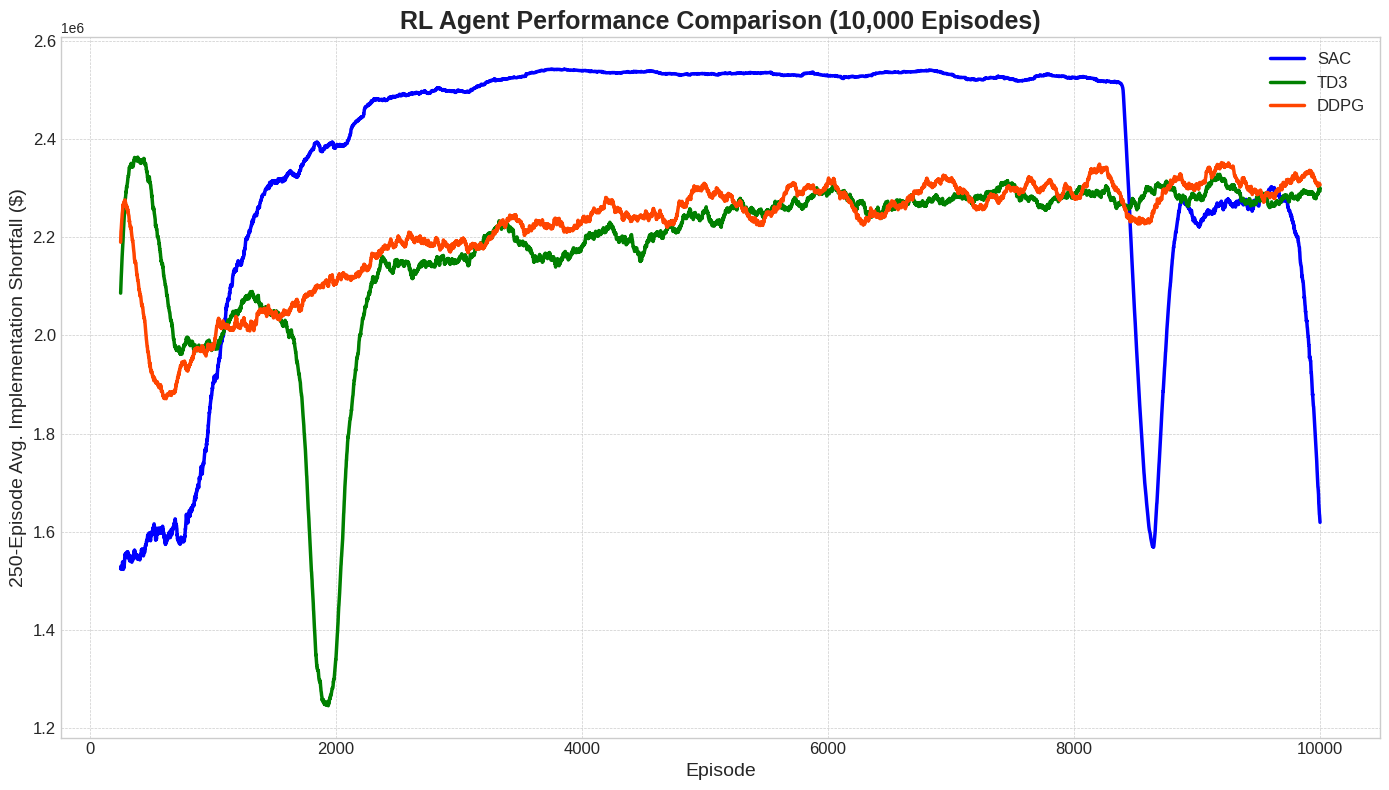


Final Performance (Average of last 250 episodes)
SAC       : $1,619,372.15
TD3       : $2,294,134.42
DDPG      : $2,307,035.71


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

experiments_to_plot = [
    {
        'name': 'SAC',
        'filename': 'results_SAC_10k.csv',
        'color': 'blue'
    },
    {
        'name': 'TD3',
        'filename': 'results_TD3_10k.csv',
        'color': 'green'
    },
    {
        'name': 'DDPG',
        'filename': 'results_DDPG_10k.csv',
        'color': 'orangered'
    }
]

print("--- Loading and Plotting Results ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

window_size = 250

for experiment in experiments_to_plot:
    try:
        df = pd.read_csv(experiment['filename'])
        moving_avg = df['shortfall'].rolling(window=window_size).mean()

        ax.plot(moving_avg.index, moving_avg, label=experiment['name'], color=experiment['color'], linewidth=2.5)
        print(f"✅ Plotted {experiment['filename']}")

    except FileNotFoundError:
        print(f"⚠️ WARNING: Could not find file {experiment['filename']}. Skipping.")

ax.set_title('RL Agent Performance Comparison (10,000 Episodes)', fontsize=18, weight='bold')
ax.set_xlabel('Episode', fontsize=14)
ax.set_ylabel(f'{window_size}-Episode Avg. Implementation Shortfall ($)', fontsize=14)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print(f"Final Performance (Average of last {window_size} episodes)")
print("="*50)
for experiment in experiments_to_plot:
    try:
        df = pd.read_csv(experiment['filename'])
        final_performance = df['shortfall'].tail(window_size).mean()
        print(f"{experiment['name']:<10}: ${final_performance:,.2f}")
    except FileNotFoundError:
        continue
print("="*50)

In [ ]:
!pip install stable-baselines3[extra] gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitli

In [ ]:
# sb3_train.py

# 1. Import necessary libraries
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env

# Import your custom environment from your file
from syntheticChrissAlmgrenGym import MarketEnvironment

# 2. Instantiate the Environment
# You can pass arguments like lambd here if you want
env = MarketEnvironment(lambd=1e-6)

# It's good practice to check the environment to ensure it's compatible
print("--- Checking Environment Compatibility ---")
check_env(env)
print("Environment is compatible with Gymnasium!\n")

# 3. Instantiate the SAC Agent
# 'MlpPolicy' is a standard neural network policy.
# Stable Baselines3 automatically detects the action and observation spaces from the env.
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,  # Set to 1 to see training logs (e.g., rewards, episode length)
    tensorboard_log="./sac_almgren_tensorboard/" # Directory for TensorBoard logs
)

# 4. Train the Agent
print("--- Starting Training ---")
# We'll train for 100,000 timesteps. You can increase this for better performance.
model.learn(total_timesteps=10_000, log_interval=4)
print("--- Training Finished ---")

# 5. Save the Trained Model
model.save("sac_almgren_model")
print(f"Model saved to sac_almgren_model.zip")


# 6. Evaluate the Trained Agent
print("\n--- Evaluating Trained Agent ---")
obs, info = env.reset()
for i in range(env.num_n + 1): # Run for one full episode
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    # Print the progress of the liquidation
    remaining_shares = obs[7] * env.total_shares
    print(f"Step {i+1}: Action={action[0]:.3f}, Shares Remaining={remaining_shares:,.0f}, Reward={reward:.4f}")

    if terminated or truncated:
        print("\n--- Episode Finished ---")
        if 'implementation_shortfall' in info:
            print(f"Final Implementation Shortfall: ${info['implementation_shortfall']:,.2f}")
        break

env.close()

--- Checking Environment Compatibility ---
Environment is compatible with Gymnasium!

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--- Starting Training ---
Logging to ./sac_almgren_tensorboard/SAC_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 48.6     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2187     |
|    time_elapsed    | 0        |
|    total_timesteps | 61       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.5     |
|    ep_rew_mean     | 48.7     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 835      |
|    time_elapsed    | 0        |
|    total_timesteps | 108      |
| train/             |          |
|    actor_loss      | -0.936   |
|    critic_loss     | 85.7     |
| 

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/financial-20250724T092407Z-1-001/financial/finance')

In [ ]:
import pandas as pd
from stable_baselines3 import SAC, PPO, TD3

# Import your custom environment from your file
from syntheticChrissAlmgrenGym import MarketEnvironment

if __name__ == '__main__':
    # --- Experiment Settings ---
    TIMESTEPS = 10_000
    EPISODES = 1
    LAMBDA = 1e-6
    AGENTS_TO_RUN = ['sac', 'ppo', 'td3'] # List of agents to train

    # --- Instantiate the Environment ---
    env = MarketEnvironment(lambd=LAMBDA)

    # --- Loop Through and Run Each Agent Configuration ---
    for agent_name in AGENTS_TO_RUN:
        agent_name = agent_name.lower()
        model_filename = f"{agent_name}_almgren_model"
        trajectory_filename = f"{agent_name}_trajectory.csv"

        print(f"\n" + "="*50)
        print(f"Starting Experiment for: {agent_name.upper()}")
        print("="*50)

        # 1. Instantiate the selected Agent
        if agent_name == "sac":
            model = SAC("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard_logs/")
        elif agent_name == "ppo":
            model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard_logs/")
        elif agent_name == "td3":
            model = TD3("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard_logs/")
        else:
            print(f"Agent '{agent_name}' not supported. Skipping.")
            continue

        # 2. Train the Agent
        print(f"--- Training {agent_name.upper()} Agent ---")
        model.learn(total_timesteps=TIMESTEPS, log_interval=10)
        print("--- Training Finished ---")

        # 3. Save the Trained Model
        model.save(model_filename)
        print(f"\n✅ Model saved to {model_filename}.zip")

        # 4. Evaluate the Trained Agent
        print(f"\n--- Evaluating {agent_name.upper()} Agent ---")
        obs, info = env.reset(seed=1337) # Use a fixed seed for consistent evaluation

        trajectory = []
        initial_shares = env.total_shares
        trajectory.append({'step': 0, 'shares_remaining': initial_shares})

        for i in range(env.num_n + 1):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)

            remaining_shares = obs[7] * initial_shares
            trajectory.append({'step': i + 1, 'shares_remaining': remaining_shares})

            if terminated or truncated:
                print("--- Episode Finished ---")
                print(f"Final Implementation Shortfall: ${info.get('implementation_shortfall', 0):,.2f}")
                break

        # 5. Save the evaluation trajectory to a CSV file
        trajectory_df = pd.DataFrame(trajectory)
        trajectory_df.to_csv(trajectory_filename, index=False)
        print(f"✅ Trajectory saved to {trajectory_filename}")

    env.close()
    print("\n--- All experiments complete! ---")


Starting Experiment for: SAC
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--- Training SAC Agent ---
Logging to ./tensorboard_logs/SAC_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.3     |
|    ep_rew_mean     | 48.3     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 263      |
|    time_elapsed    | 0        |
|    total_timesteps | 143      |
| train/             |          |
|    actor_loss      | -2.38    |
|    critic_loss     | 47.9     |
|    ent_coef        | 0.988    |
|    ent_coef_loss   | -0.0208  |
|    learning_rate   | 0.0003   |
|    n_updates       | 42       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.7     |
|    ep_rew_mean     | 48.2     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 146    

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    episodes        | 5810     |
|    fps             | 147      |
|    time_elapsed    | 40       |
|    total_timesteps | 5940     |
| train/             |          |
|    actor_loss      | -45.4    |
|    critic_loss     | 0.00199  |
|    learning_rate   | 0.001    |
|    n_updates       | 5839     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 47.4     |
| time/              |          |
|    episodes        | 5820     |
|    fps             | 147      |
|    time_elapsed    | 40       |
|    total_timesteps | 5950     |
| train/             |          |
|    actor_loss      | -46.5    |
|    critic_loss     | 0.00148  |
|    learning_rate   | 0.001    |
|    n_updates       | 5849     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1       

--- Loading agent trajectories ---
✅ Loaded sac_trajectory.csv
✅ Loaded ppo_trajectory.csv
✅ Loaded td3_trajectory.csv

--- Calculating Almgren-Chriss benchmark trajectory ---
❌ An unexpected error occurred during benchmark calculation: MarketEnvironment.__init__() got an unexpected keyword argument 'liquid_time'


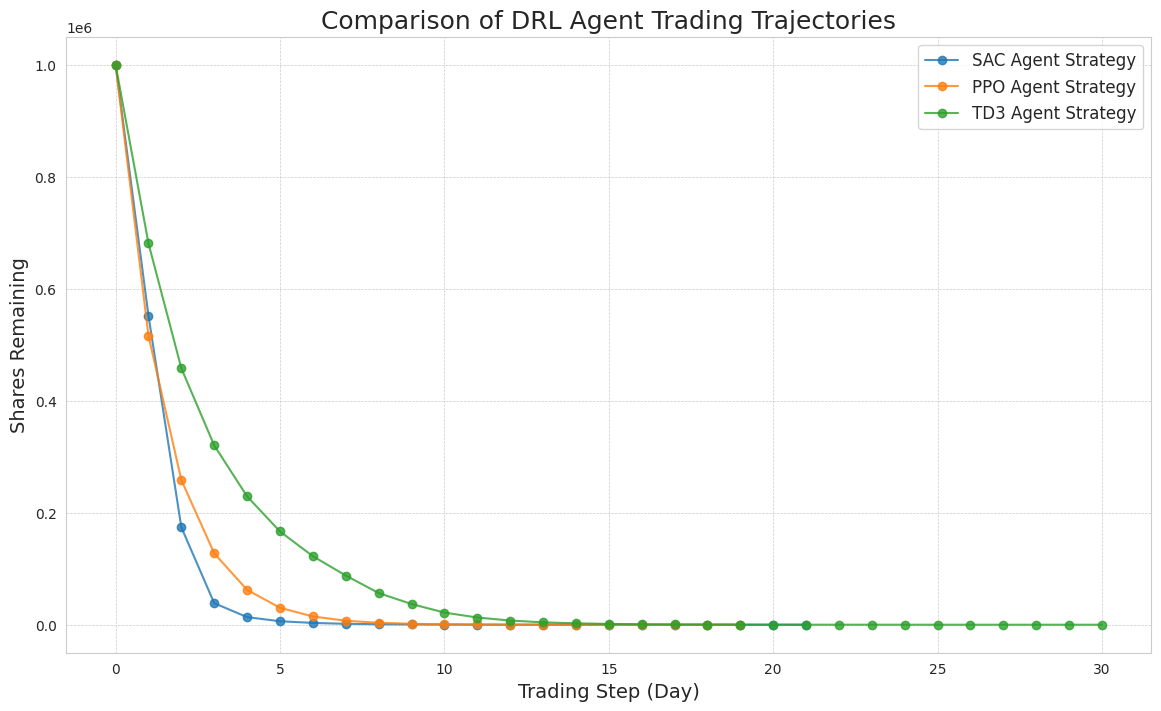

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your 'utils.py' file has the function to get the AC trade list
# import utils # No longer importing utils for get_trade_list

# Import syntheticChrissAlmgren for the benchmark calculation
import syntheticChrissAlmgren as sca

# --- SETTINGS ---
LAMBDA = 1e-6 # The risk aversion used for training

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# --- 1. Load the Trajectories for Each DRL Agent ---
agent_names = ['sac', 'ppo', 'td3']
agent_trajectories = {}

print("--- Loading agent trajectories ---")
for name in agent_names:
    try:
        filename = f'{name}_trajectory.csv'
        agent_trajectories[name.upper()] = pd.read_csv(filename)
        print(f"✅ Loaded {filename}")
    except FileNotFoundError:
        print(f"⚪️ File not found for {name}. Please run the evaluation script first.")

# --- 2. Calculate the Analytical Almgren-Chriss Trajectory ---
# This is the benchmark strategy from your earlier notebooks.
print("\n--- Calculating Almgren-Chriss benchmark trajectory ---")
# Attempt to use the syntheticChrissAlmgren module to get the benchmark
try:
    # Instantiate the environment with the same parameters as training
    env_benchmark = sca.MarketEnvironment(liquid_time=60, num_trades=60, lamb=LAMBDA)
    # Get the Almgren-Chriss trade list from the environment's internal calculation
    ac_trade_list = env_benchmark.get_chriss_almgren_trade_list()
    # Calculate the shares remaining over time
    # Initial shares + cumulative sum of negative trade list
    ac_shares_remaining = np.cumsum(np.insert(-ac_trade_list, 0, 0)) + env_benchmark.total_shares

    ac_df = pd.DataFrame({
        'step': np.arange(len(ac_shares_remaining)),
        'shares_remaining': ac_shares_remaining
    })
    print("✅ Almgren-Chriss benchmark calculated successfully.")

except AttributeError:
    print("❌ Error: Could not calculate Almgren-Chriss benchmark. Check if syntheticChrissAlmgren has get_chriss_almgren_trade_list.")
    ac_df = None # Set to None if calculation fails
except Exception as e:
    print(f"❌ An unexpected error occurred during benchmark calculation: {e}")
    ac_df = None


# --- 3. Plot the Comparison ---
if agent_trajectories or (ac_df is not None):
    plt.figure()

    # Plot each DRL agent's strategy
    for name, df in agent_trajectories.items():
        plt.plot(df['step'], df['shares_remaining'], 'o-', label=f'{name} Agent Strategy', alpha=0.8)

    # Plot the Almgren-Chriss benchmark strategy if calculated
    if ac_df is not None:
        plt.plot(ac_df['step'], ac_df['shares_remaining'], 's--', label='Almgren-Chriss Benchmark', color='black', linewidth=2)

    plt.title('Comparison of DRL Agent Trading Trajectories', fontsize=18)
    plt.xlabel('Trading Step (Day)', fontsize=14)
    plt.ylabel('Shares Remaining', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
else:
    print("\n❌ No trajectories loaded and benchmark could not be calculated. Cannot plot.")

In [ ]:
# sb3_train.py

# 1. Import necessary libraries
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Import your custom environment from your file
from syntheticChrissAlmgrenGym import MarketEnvironment

# 2. Instantiate the Environment
# You can pass arguments like lambd here if you want
env = MarketEnvironment(lambd=1e-6)

# It's good practice to check the environment to ensure it's compatible
print("--- Checking Environment Compatibility ---")
check_env(env)
print("Environment is compatible with Gymnasium!\n")

# 3. Instantiate the SAC Agent
# 'MlpPolicy' is a standard neural network policy.
# Stable Baselines3 automatically detects the action and observation spaces from the env.
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,  # Set to 1 to see training logs (e.g., rewards, episode length)
    tensorboard_log="./sac_almgren_tensorboard/" # Directory for TensorBoard logs
)

# 4. Train the Agent
print("--- Starting Training ---")
# We'll train for 100,000 timesteps. You can increase this for better performance.
model.learn(total_timesteps=10_000, log_interval=4)
print("--- Training Finished ---")

# 5. Save the Trained Model
model.save("sac_almgren_model")
print(f"Model saved to sac_almgren_model.zip")


# 6. Evaluate the Trained Agent
print("\n--- Evaluating Trained Agent ---")
obs, info = env.reset()
for i in range(env.num_n + 1): # Run for one full episode
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    # Print the progress of the liquidation
    remaining_shares = obs[7] * env.total_shares
    print(f"Step {i+1}: Action={action[0]:.3f}, Shares Remaining={remaining_shares:,.0f}, Reward={reward:.4f}")

    if terminated or truncated:
        print("\n--- Episode Finished ---")
        if 'implementation_shortfall' in info:
            print(f"Final Implementation Shortfall: ${info['implementation_shortfall']:,.2f}")
        break

env.close()

--- Checking Environment Compatibility ---
Environment is compatible with Gymnasium!

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--- Starting Training ---
Logging to ./sac_almgren_tensorboard/SAC_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.5     |
|    ep_rew_mean     | 48.7     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2252     |
|    time_elapsed    | 0        |
|    total_timesteps | 62       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15       |
|    ep_rew_mean     | 48.6     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 465      |
|    time_elapsed    | 0        |
|    total_timesteps | 120      |
| train/             |          |
|    actor_loss      | -1.46    |
|    critic_loss     | 89       |
| 

In [ ]:
# sb3_train.py

# 1. Import necessary libraries
from stable_baselines3 import TD3
from stable_baselines3.common.env_checker import check_env

# Import your custom environment from your file
from syntheticChrissAlmgrenGym import MarketEnvironment

# 2. Instantiate the Environment
# You can pass arguments like lambd here if you want
env = MarketEnvironment(lambd=1e-6)

# It's good practice to check the environment to ensure it's compatible
print("--- Checking Environment Compatibility ---")
check_env(env)
print("Environment is compatible with Gymnasium!\n")

# 3. Instantiate the SAC Agent
# 'MlpPolicy' is a standard neural network policy.
# Stable Baselines3 automatically detects the action and observation spaces from the env.
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,  # Set to 1 to see training logs (e.g., rewards, episode length)
    tensorboard_log="./sac_almgren_tensorboard/" # Directory for TensorBoard logs
)

# 4. Train the Agent
print("--- Starting Training ---")
# We'll train for 100,000 timesteps. You can increase this for better performance.
model.learn(total_timesteps=10_000, log_interval=4)
print("--- Training Finished ---")

# 5. Save the Trained Model
model.save("sac_almgren_model")
print(f"Model saved to sac_almgren_model.zip")


# 6. Evaluate the Trained Agent
print("\n--- Evaluating Trained Agent ---")
obs, info = env.reset()
for i in range(env.num_n + 1): # Run for one full episode
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    # Print the progress of the liquidation
    remaining_shares = obs[7] * env.total_shares
    print(f"Step {i+1}: Action={action[0]:.3f}, Shares Remaining={remaining_shares:,.0f}, Reward={reward:.4f}")

    if terminated or truncated:
        print("\n--- Episode Finished ---")
        if 'implementation_shortfall' in info:
            print(f"Final Implementation Shortfall: ${info['implementation_shortfall']:,.2f}")
        break

env.close()

--- Checking Environment Compatibility ---
Environment is compatible with Gymnasium!

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--- Starting Training ---
Logging to ./sac_almgren_tensorboard/SAC_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.5     |
|    ep_rew_mean     | 49.3     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2273     |
|    time_elapsed    | 0        |
|    total_timesteps | 58       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | 48.6     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1055     |
|    time_elapsed    | 0        |
|    total_timesteps | 106      |
| train/             |          |
|    actor_loss      | -0.812   |
|    critic_loss     | 107      |
| 

baseline TD3 for 100_000 timesteps

In [8]:
# 1. Import necessary libraries
import numpy as np
from stable_baselines3 import TD3 #
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise # TD3 often uses action noise

from syntheticChrissAlmgrenGym import MarketEnvironment

# 2. Instantiate the Environment
env = MarketEnvironment(lambd=1e-6)
# Wrap the environment in a Monitor to automatically track episode stats
env = Monitor(env)

print("--- Checking Environment Compatibility ---")
check_env(env)
print("Environment is compatible with Gymnasium!\n")

# 3. Instantiate the TD3 Agent
# TD3 requires action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = TD3(
    "MlpPolicy",
    env,
    action_noise=action_noise,
    verbose=1,
    tensorboard_log="./td3_almgren_tensorboard/" # <-- CHANGE: Updated log name
)

# 4. Train the Agent
print("--- Starting Training ---")
model.learn(total_timesteps=100_000, log_interval=4)
print("--- Training Finished ---")

# 5. Save the Trained Model
model.save("td3_almgren_model") # <-- CHANGE: Updated model name
print(f"Model saved to td3_almgren_model.zip")


# --- 6. Evaluate Over Multiple Episodes for Average Shortfall ---
print("\n--- Evaluating Trained Agent for Average Shortfall ---")

EVALUATION_EPISODES = 100
shortfall_history = []

for episode in range(EVALUATION_EPISODES):
    obs, info = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    if 'episode' in info:
        final_info = info['episode']
        if 'implementation_shortfall' in final_info:
            shortfall_history.append(final_info['implementation_shortfall'])

    print(f"\rEvaluating episode {episode + 1}/{EVALUATION_EPISODES}", end="")

print("\n--- Evaluation Finished ---")

if shortfall_history:
    average_shortfall = np.mean(shortfall_history)
    print(f"\nAverage Implementation Shortfall over {EVALUATION_EPISODES} episodes: ${average_shortfall:,.2f}")

# --- 7. Run a Single Verbose Episode to See the Strategy ---
print("\n--- Running a Single Detailed Episode ---")
obs, info = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Print the progress of the liquidation
    # Note: Accessing env attributes after wrapping requires .get_attr()
    remaining_shares = obs[7] * model.get_env().get_attr('total_shares')[0]
    print(f"Action={action[0]:.3f}, Shares Remaining={remaining_shares:,.0f}, Reward={reward:.4f}")

print("\n--- Episode Finished ---")
if 'implementation_shortfall' in info:
    # Print the final implementation shortfall for this specific run
    print(f"Final Implementation Shortfall: ${info['implementation_shortfall']:,.2f}")

env.close()

ModuleNotFoundError: No module named 'stable_baselines3'

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/financial-20250724T092407Z-1-001/financial/finance')